In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [20]:
df = pd.read_csv("data/MSFT.csv")


new_df = df[['Date', 'Adj Close']]
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df



C:\Users\Nisarg\AppData\Local\Temp\ipykernel_33336\1906250217.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Date'] = pd.to_datetime(new_df['Date'])


,Date,Adj Close
0,1986-03-13,0.060055
1,1986-03-14,0.062199
2,1986-03-17,0.063272
3,1986-03-18,0.061663
4,1986-03-19,0.060591
...,...,...
9637,2024-06-10,427.869995
9638,2024-06-11,432.679993
9639,2024-06-12,441.059998
9640,2024-06-13,441.579987


In [21]:
# Function to calculate Weighted Moving Average (WMA)
def calculate_wma(prices, window):
    weights = np.arange(1, window + 1)
    wma = prices.rolling(window).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return wma

# Function to calculate Relative Strength Index (RSI)
def calculate_rsi(prices, window):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_fibonacci_levels(prices, window):
    high_price = prices.rolling(window).max()
    low_price = prices.rolling(window).min()
    difference = high_price - low_price
    level1 = high_price - difference * 0.236
    level2 = high_price - difference * 0.382
    level3 = high_price - difference * 0.618
    return level1, level2, level3

In [22]:
new_df['WMA'] = calculate_wma(new_df['Adj Close'], 14)

new_df['RSI'] = calculate_rsi(new_df['Adj Close'], 14)

high_price = new_df['Adj Close'].max()
low_price = new_df['Adj Close'].min()
level1,level2,level3 = calculate_fibonacci_levels(new_df['Adj Close'], 14)
new_df['Fib 23.6%'] = level1
new_df['Fib 38.2%'] = level2
new_df['Fib 61.8%'] = level3


C:\Users\Nisarg\AppData\Local\Temp\ipykernel_33336\2510357506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['WMA'] = calculate_wma(new_df['Adj Close'], 14)
C:\Users\Nisarg\AppData\Local\Temp\ipykernel_33336\2510357506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['RSI'] = calculate_rsi(new_df['Adj Close'], 14)
C:\Users\Nisarg\AppData\Local\Temp\ipykernel_33336\2510357506.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [23]:
new_df.dropna(inplace=True)
new_df

,Date,Adj Close,WMA,RSI,Fib 23.6%,Fib 38.2%,Fib 61.8%
13,1986-04-02,0.058982,0.058758,46.666924,0.061501,0.060404,0.058633
14,1986-04-03,0.059518,0.058778,48.387246,0.061501,0.060404,0.058633
15,1986-04-04,0.059518,0.058803,40.741559,0.061501,0.060404,0.058633
16,1986-04-07,0.058446,0.058712,33.332004,0.060271,0.059410,0.058018
17,1986-04-08,0.058982,0.058737,40.000033,0.059452,0.058747,0.057609
...,...,...,...,...,...,...,...
9637,2024-06-10,427.869995,422.695526,52.784505,426.507989,424.025989,420.013989
9638,2024-06-11,432.679993,423.854286,53.910602,428.158232,425.360871,420.839110
9639,2024-06-12,441.059998,426.095714,59.861540,434.560556,430.539714,424.040272
9640,2024-06-13,441.579987,428.306093,64.452810,434.957827,430.861068,424.238908


In [32]:
# Step 8: Generate buy, sell, and neutral signals for WMA
new_df['WMA Signal'] = np.where(new_df['Adj Close'] > new_df['WMA'], 'Buy',
                                np.where(new_df['Adj Close'] < new_df['WMA'], 'Sell', 'Neutral'))

# Step 9: Generate buy, sell, and neutral signals for RSI
new_df['RSI Signal'] = np.where(new_df['RSI'] < 30, 'Buy',
                                np.where(new_df['RSI'] > 70, 'Sell', 'Neutral'))

# Step 10: Generate buy, sell, and neutral signals for Fibonacci levels
new_df['Fib Signal'] = 'Neutral'
new_df.loc[(new_df['Adj Close'] > new_df['Fib 23.6%']) & (new_df['Adj Close'].shift(1) <= new_df['Fib 23.6%']), 'Fib Signal'] = 'Buy'
new_df.loc[(new_df['Adj Close'] < new_df['Fib 23.6%']) & (new_df['Adj Close'].shift(1) >= new_df['Fib 23.6%']), 'Fib Signal'] = 'Sell'
new_df.loc[(new_df['Adj Close'] > new_df['Fib 38.2%']) & (new_df['Adj Close'].shift(1) <= new_df['Fib 38.2%']), 'Fib Signal'] = 'Buy'
new_df.loc[(new_df['Adj Close'] < new_df['Fib 38.2%']) & (new_df['Adj Close'].shift(1) >= new_df['Fib 38.2%']), 'Fib Signal'] = 'Sell'
new_df.loc[(new_df['Adj Close'] > new_df['Fib 61.8%']) & (new_df['Adj Close'].shift(1) <= new_df['Fib 61.8%']), 'Fib Signal'] = 'Buy'
new_df.loc[(new_df['Adj Close'] < new_df['Fib 61.8%']) & (new_df['Adj Close'].shift(1) >= new_df['Fib 61.8%']), 'Fib Signal'] = 'Sell'

new_df['All Signal'] = np.where((new_df['WMA Signal'] == 'Buy') & (new_df['RSI Signal'] == 'Buy') & (new_df['Fib Signal'] == 'Buy'), 'Buy',
                                np.where((new_df['WMA Signal'] == 'Sell') & (new_df['RSI Signal'] == 'Sell') & (new_df['Fib Signal'] == 'Sell'), 'Sell', 'Neutral'))


In [33]:
new_df

,Date,Adj Close,WMA,RSI,Fib 23.6%,Fib 38.2%,Fib 61.8%,WMA Signal,RSI Signal,Fib Signal,all_signal,All Signal
13,1986-04-02,0.058982,0.058758,46.666924,0.061501,0.060404,0.058633,Buy,Neutral,Neutral,Neutral,Neutral
14,1986-04-03,0.059518,0.058778,48.387246,0.061501,0.060404,0.058633,Buy,Neutral,Neutral,Neutral,Neutral
15,1986-04-04,0.059518,0.058803,40.741559,0.061501,0.060404,0.058633,Buy,Neutral,Neutral,Neutral,Neutral
16,1986-04-07,0.058446,0.058712,33.332004,0.060271,0.059410,0.058018,Sell,Neutral,Sell,Neutral,Neutral
17,1986-04-08,0.058982,0.058737,40.000033,0.059452,0.058747,0.057609,Buy,Neutral,Buy,Neutral,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
9637,2024-06-10,427.869995,422.695526,52.784505,426.507989,424.025989,420.013989,Buy,Neutral,Buy,Neutral,Neutral
9638,2024-06-11,432.679993,423.854286,53.910602,428.158232,425.360871,420.839110,Buy,Neutral,Buy,Neutral,Neutral
9639,2024-06-12,441.059998,426.095714,59.861540,434.560556,430.539714,424.040272,Buy,Neutral,Buy,Neutral,Neutral
9640,2024-06-13,441.579987,428.306093,64.452810,434.957827,430.861068,424.238908,Buy,Neutral,Neutral,Neutral,Neutral


In [51]:
def calculate_profit(df,singal, entry_date=None, exit_date=None, initial_cash=10000):
    cash = initial_cash
    stock = 0
    portfolio_value = []
     # Filter dataframe between entry and exit dates
    df = df[(df['Date'] >= entry_date) & (df['Date'] <= exit_date)]

    for i in range(len(df)):
        if df[singal].iloc[i] == 'Buy' and cash > 0:
            # Buy as many stocks as possible with available cash
            stock = cash / df['Adj Close'].iloc[i]
            cash = 0
        elif df[singal].iloc[i] == 'Sell' and stock > 0:
            # Sell all stocks
            cash = stock * df['Adj Close'].iloc[i]
            stock = 0

        # Calculate the current value of the portfolio
        current_value = cash + stock * df['Adj Close'].iloc[i]
        portfolio_value.append(current_value)

    final_value = cash + stock * df['Adj Close'].iloc[-1]
    profit = final_value - initial_cash
    profit_percentage = (profit / initial_cash) * 100
    return profit, portfolio_value, profit_percentage

# Specify entry and exit dates
exit_date = pd.to_datetime('2024-06-14')
entry_date = exit_date - pd.Timedelta(days=360)




profit, portfolio_value,profit_percentage = calculate_profit(new_df,"WMA Signal",entry_date,exit_date)
print(f"WMA Signal : Final Profit: ${profit:.2f}, {profit_percentage.round(2)}%")

profit, portfolio_value,profit_percentage = calculate_profit(new_df,"RSI Signal",entry_date,exit_date)
print(f"RSI Signal : Final Profit: ${profit:.2f}, {profit_percentage.round(2)}%")

profit, portfolio_value,profit_percentage = calculate_profit(new_df,"Fib Signal",entry_date,exit_date)
print(f"Fib Signal : Final Profit: ${profit:.2f}, {profit_percentage.round(2)}%")

profit, portfolio_value,profit_percentage = calculate_profit(new_df,"All Signal",entry_date,exit_date)
print(f"All Signal : Final Profit: ${profit:.2f}, {profit_percentage.round(2)}%")


WMA Signal : Final Profit: $1007.10, 10.07%
RSI Signal : Final Profit: $1545.10, 15.45%
Fib Signal : Final Profit: $639.87, 6.4%
All Signal : Final Profit: $0.00, 0.0%


In [50]:
# Calculate count of Buy, Sell, and Neutral for each signal column
wma_counts = new_df['WMA Signal'].value_counts()
rsi_counts = new_df['RSI Signal'].value_counts()
fib_counts = new_df['Fib Signal'].value_counts()
all_signal_counts = new_df['all_signal'].value_counts()

# Print the counts
print("WMA Signal Counts:")
print(wma_counts)
print("\nRSI Signal Counts:")
print(rsi_counts)
print("\nFib Signal Counts:")
print(fib_counts)
print("\nAll Signal Counts:")
print(all_signal_counts)

WMA Signal Counts:
WMA Signal
Buy     5561
Sell    4068
Name: count, dtype: int64

RSI Signal Counts:
RSI Signal
Neutral    7250
Sell       1673
Buy         706
Name: count, dtype: int64

Fib Signal Counts:
Fib Signal
Neutral    5940
Buy        2023
Sell       1666
Name: count, dtype: int64

All Signal Counts:
all_signal
Neutral    9597
Sell         29
Buy           3
Name: count, dtype: int64


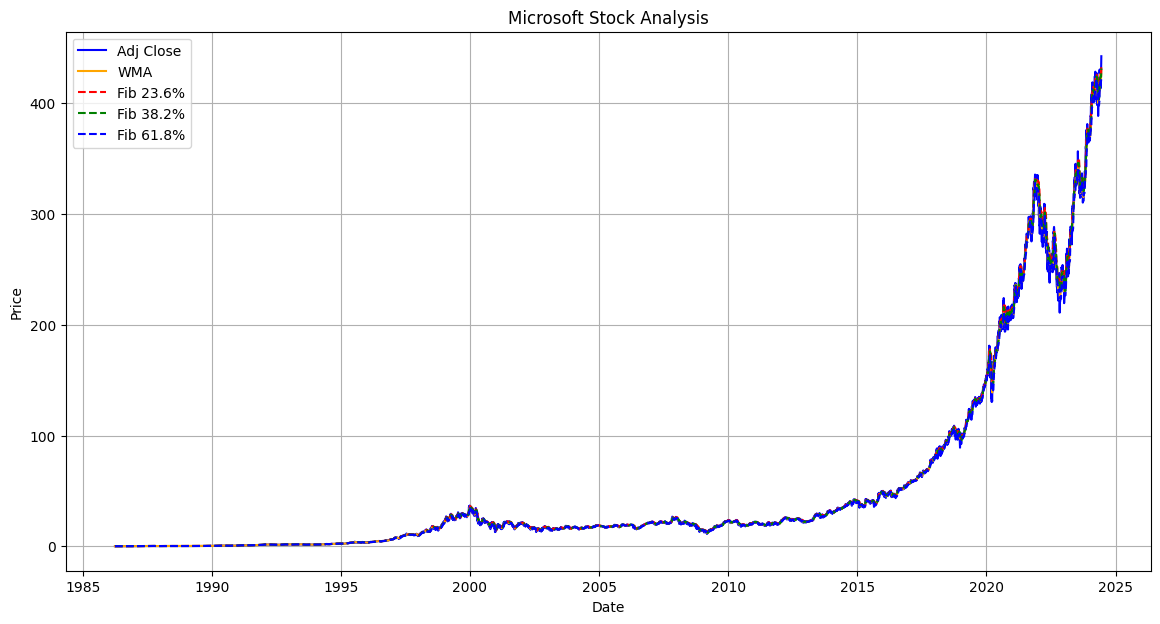

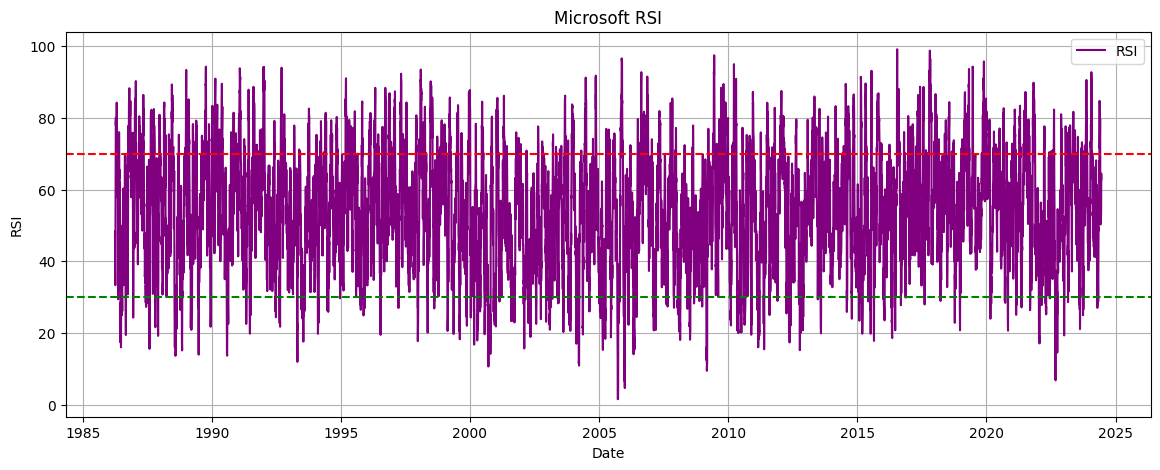

In [25]:

# Step 12: Plot the chart with indicators
plt.figure(figsize=(14, 7))

# Plot Adjusted Close Price and WMA
plt.plot(new_df['Date'], new_df['Adj Close'], label='Adj Close', color='blue')
plt.plot(new_df['Date'], new_df['WMA'], label='WMA', color='orange')

# Plot Fibonacci Levels
plt.plot(new_df['Date'], new_df['Fib 23.6%'], color='r', linestyle='--', label='Fib 23.6%')
plt.plot(new_df['Date'], new_df['Fib 38.2%'], color='g', linestyle='--', label='Fib 38.2%')
plt.plot(new_df['Date'], new_df['Fib 61.8%'], color='b', linestyle='--', label='Fib 61.8%')

plt.title(f'{ticker} Stock Analysis')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot RSI
plt.figure(figsize=(14, 5))
plt.plot(new_df['Date'], new_df['RSI'], label='RSI', color='purple')
plt.axhline(70, color='r', linestyle='--')
plt.axhline(30, color='g', linestyle='--')
plt.title(f'{ticker} RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.show()